In [11]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [53]:
#import libraries and functions to load the data
from digits import get_mnist
from matplotlib import pyplot as plt
import numpy as np


import torch
from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

In [54]:
# # Download training data from open datasets.
# training_data = datasets.MNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor(),
# )

# # Download test data from open datasets.
# test_data = datasets.MNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor(),
# )

In [46]:
# batch_size = 64

# # Create data loaders.
# train_dataloader = DataLoader(training_data, batch_size=batch_size)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)

# for X, y in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


trX.shape:  (784, 10000)
trY.shape:  (1, 10000)
tsX.shape:  (784, 10000)
tsY.shape:  (1, 10000)

Displaying a few samples
labels
[[0 9 0 5 0 7 0 0 5 6]
 [0 5 4 4 6 7 3 0 9 7]
 [8 8 8 7 6 2 2 1 9 6]
 [8 1 7 2 0 3 5 2 7 6]
 [1 0 6 3 8 0 4 1 5 5]
 [7 4 6 2 5 5 0 6 3 0]
 [2 3 4 1 6 3 7 2 0 7]
 [1 8 5 9 7 2 8 8 0 3]
 [1 9 1 0 8 7 8 0 0 2]
 [2 3 3 3 4 6 6 6 3 3]]

Corresponding images


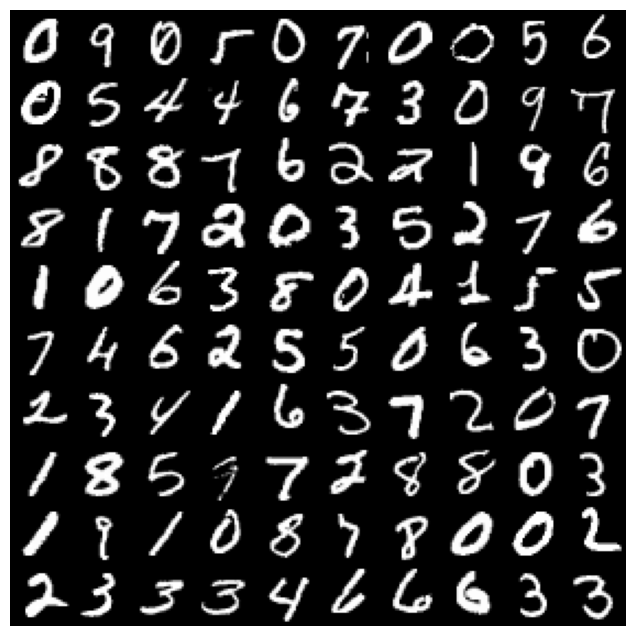

In [58]:
# The data is of the format (no_samples, channels, img_height, img_width)
# We will reshape it to (img_height*img_width, no_samples)
# In the training data trX, there are 60000 images. Each image has one channel (gray scale). 
# Each image is of height=28 and width=28 pixels
# We will use only 5000 training examples and all the 10000 test samples. 

def sample_mnist(n_train=10000, n_test=10000):
    trX, trY, tsX, tsY = get_mnist()
    #Shuffle the data.
    tr_idx = np.random.choice(trX.shape[0], n_train)
    trX = trX[tr_idx]
    trY = trY[tr_idx]
    ts_idx = np.random.choice(tsX.shape[0], n_test)
    tsX = tsX[ts_idx]
    tsY = tsY[ts_idx]
    # Reshape to [n x m]. n dimensions and m samples
    trX = trX.reshape(-1, 28*28).T
    trY = trY.reshape(1, -1)
    tsX = tsX.reshape(-1, 28*28).T
    tsY = tsY.reshape(1, -1)
    return trX, trY, tsX, tsY 

# Lets verify the function
# Random seed for reproducibility
np.random.seed(1)
trX, trY, tsX, tsY = sample_mnist(n_train=10000, n_test=10000)
# Lets examine the data and see if it is normalized
print('trX.shape: ', trX.shape)
print('trY.shape: ', trY.shape)
print('tsX.shape: ', tsX.shape)
print('tsY.shape: ', tsY.shape)

# Let's visualize a few samples and their labels from the train and test datasets.
print('\nDisplaying a few samples')
visx = np.concatenate((trX[:,:50],tsX[:,:50]), axis=1).reshape(28,28,10,10).transpose(2,0,3,1).reshape(28*10,-1)
visy = np.concatenate((trY[:,:50],tsY[:,:50]), axis=1).reshape(10,-1)
print('labels')
print(visy)
print('\nCorresponding images')
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(visx, cmap='gray');

#convert numpy arrays to torch tensors becasue PyTorch autograd needs tensor format
trX = torch.tensor(trX, dtype=torch.float32)
trY = torch.tensor(trY, dtype=torch.int64).squeeze()
tsX = torch.tensor(tsX, dtype=torch.float32)
tsY = torch.tensor(tsY, dtype=torch.int64).squeeze()

In [56]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# model = NeuralNetwork().to(device)
model = NeuralNetwork()

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
    (3): ReLU()
  )
)


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [64]:
def train(dataloader, model, loss_fn, optimizer):
    # size = len(dataloader.dataset)
    size = len(dataloader)
    
    model.train()
    for X, y in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        X, y = X, y
        

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [50]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            X, y = X, y
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trX, model, loss_fn, optimizer)
    test(tsX, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


AttributeError: 'int' object has no attribute 'flatten'